In [1]:
import numpy as np
import matplotlib.pyplot as plt

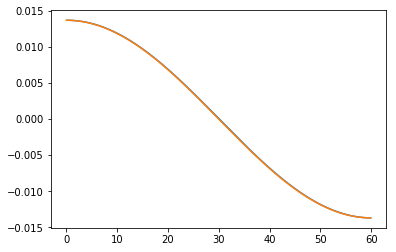

In [2]:
TOTAL_DISTANCE = 10 # meters 

TOTAL_SECONDS = 60 # seconds
SAMPLING_RATE = 10  # Hz
dt = 1 / SAMPLING_RATE

GPS_RMS_ERROR = 1 # meter
ACCELEROMETER_RMS_ERROR = .01 # m/s**2

number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE

t = np.arange(number_of_timesteps) / SAMPLING_RATE

true_acceleration = TOTAL_DISTANCE / 2 * np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS) ) * (2 * np.pi / (2 * TOTAL_SECONDS))**2
true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2


plt.plot(t[2:], np.diff(np.diff(true_position)) / dt**2)
plt.plot(t, true_acceleration)

In [61]:
np.random.seed(52)

sensor_position = np.zeros((number_of_timesteps, 3))
sensor_position[:, 0] = true_position
sensor_position += np.random.randn(number_of_timesteps, 3) * GPS_RMS_ERROR

sensor_acceleration = np.zeros((number_of_timesteps, 3))
sensor_acceleration[:, 0] = true_acceleration
sensor_acceleration += np.random.randn(number_of_timesteps, 3) * ACCELEROMETER_RMS_ERROR

In [101]:
F = np.identity(6)
for i in [0, 2, 4]:
    F[i, i+1] = dt

Q = np.zeros((6,6))
for i in [0, 2, 4]:
    Q[i,i] = ACCELEROMETER_RMS_ERROR * dt**2 / 2
    Q[i+1, i+1] = ACCELEROMETER_RMS_ERROR * dt
    
Q = Q ** 2

R = np.identity(3) * GPS_RMS_ERROR**2

H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0]
])

B = np.array([
    [dt**2/2, dt, 0, 0, 0, 0],
    [0, 0, dt**2/2, dt, 0, 0],
    [0, 0, 0, 0, dt**2/2, dt]
]).T

P = Q# + R
for i in [0, 2, 4]:
    P[i, i] += GPS_RMS_ERROR ** 2



<ErrorbarContainer object of 3 artists>

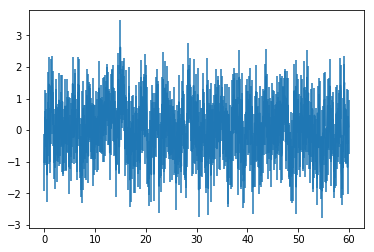

In [102]:
number_of_kalman_states = 6

kalman_states = np.empty((number_of_timesteps, number_of_kalman_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_kalman_states)) * np.nan

I = np.identity(number_of_kalman_states)

# initialize state
mu = np.array([0, 0, 0, 0, 0, 0])
P = Q# + R
for i in [0, 2, 4]:
    P[i, i] += GPS_RMS_ERROR ** 2


for time_index in range(number_of_timesteps):
    # Kalman step

    u = sensor_acceleration[time_index, :]
    z = sensor_position[time_index, :]

    #print(z)
    
    # Predict
    mu_model = F @ mu + B @ u
    P = F @ P @ F.T + Q

    # Update
    y = z - H @ mu_model # pre-fit residual
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    #print(time_index, K)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual

    
    
    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5
    
kalman_index = 2
plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index])
#plt.plot(t, true_position)


<ErrorbarContainer object of 3 artists>

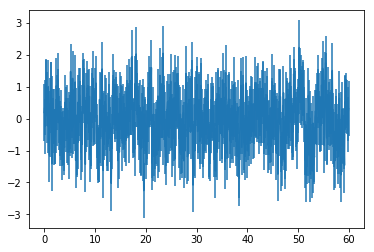

In [103]:
kalman_index = 4
plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index])

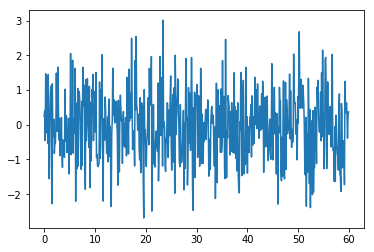

In [107]:
kalman_index = 4
plt.plot(t, sensor_position[:, 2])

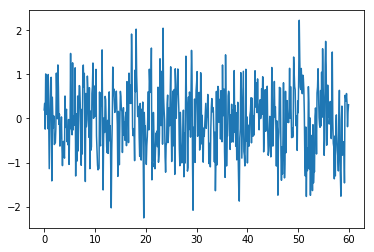

In [108]:
kalman_index = 4
plt.plot(t, (kalman_states[:, kalman_index]))

In [64]:
((I - K @ H) @ P @ (I - K @ H)).shape

(6, 6)

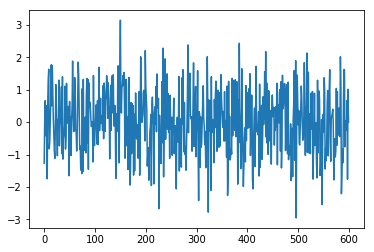

In [65]:
plt.plot(sensor_position[:, 1])

In [47]:
R.shape

(3,)